In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 12e6

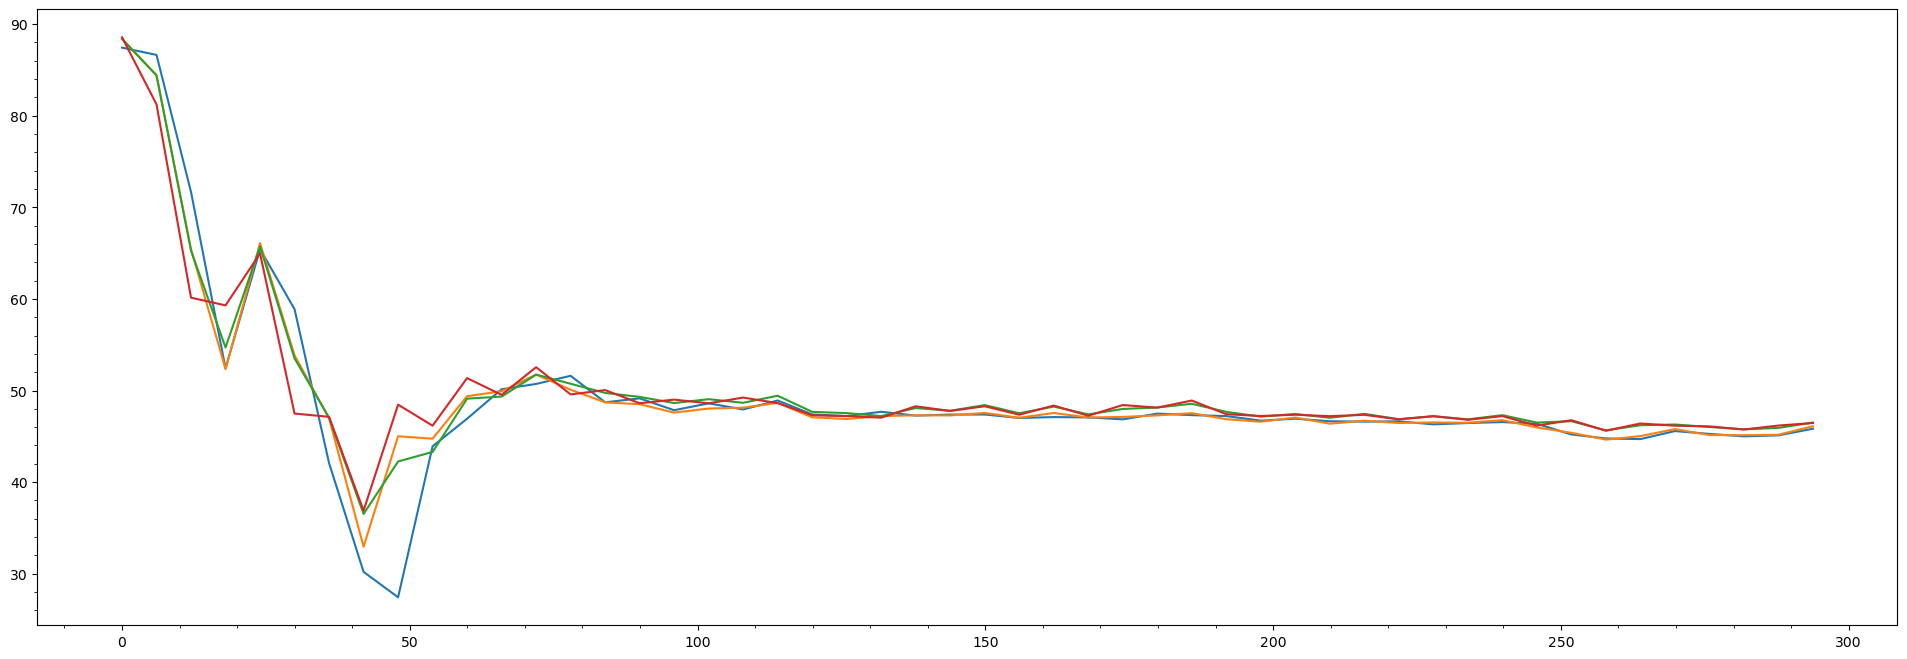

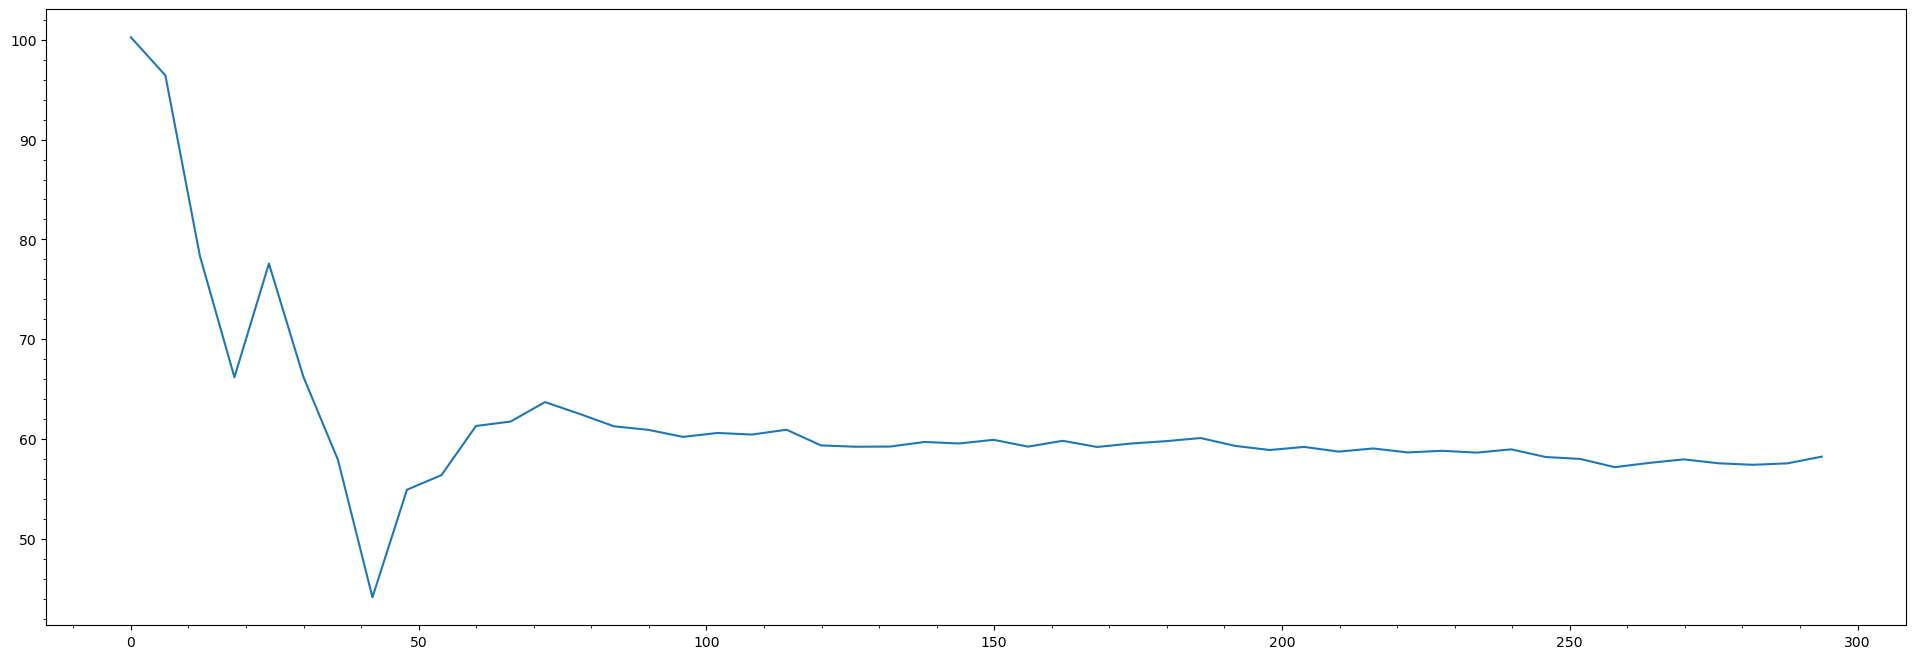

In [7]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]


def cpi(file_path, template_signal):
    data = read_iq_bin(file_path)
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    #window = kaiser(len(matched_filter), 8, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(data, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full

    # Extract pulses
    pulse_sum = np.zeros(50).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:50]
        if (len(xcorr_data_plot)==50):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break

    return pulse_sum

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

pulse_sum_0 = cpi("../outputs/outputs4/lab_scream_0.bin",template_signal)
pulse_sum_1 = cpi("../outputs/outputs4/lab_scream_1.bin",template_signal)
pulse_sum_2 = cpi("../outputs/outputs4/lab_scream_2.bin",template_signal)
pulse_sum_3 = cpi("../outputs/outputs4/lab_scream_3.bin",template_signal)

pulse_sum = pulse_sum_0 + pulse_sum_1 + pulse_sum_2 + pulse_sum_3

range_bins = np.arange(pulse_sum)

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_3)))
plt.minorticks_on()
plt.show()

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.show()

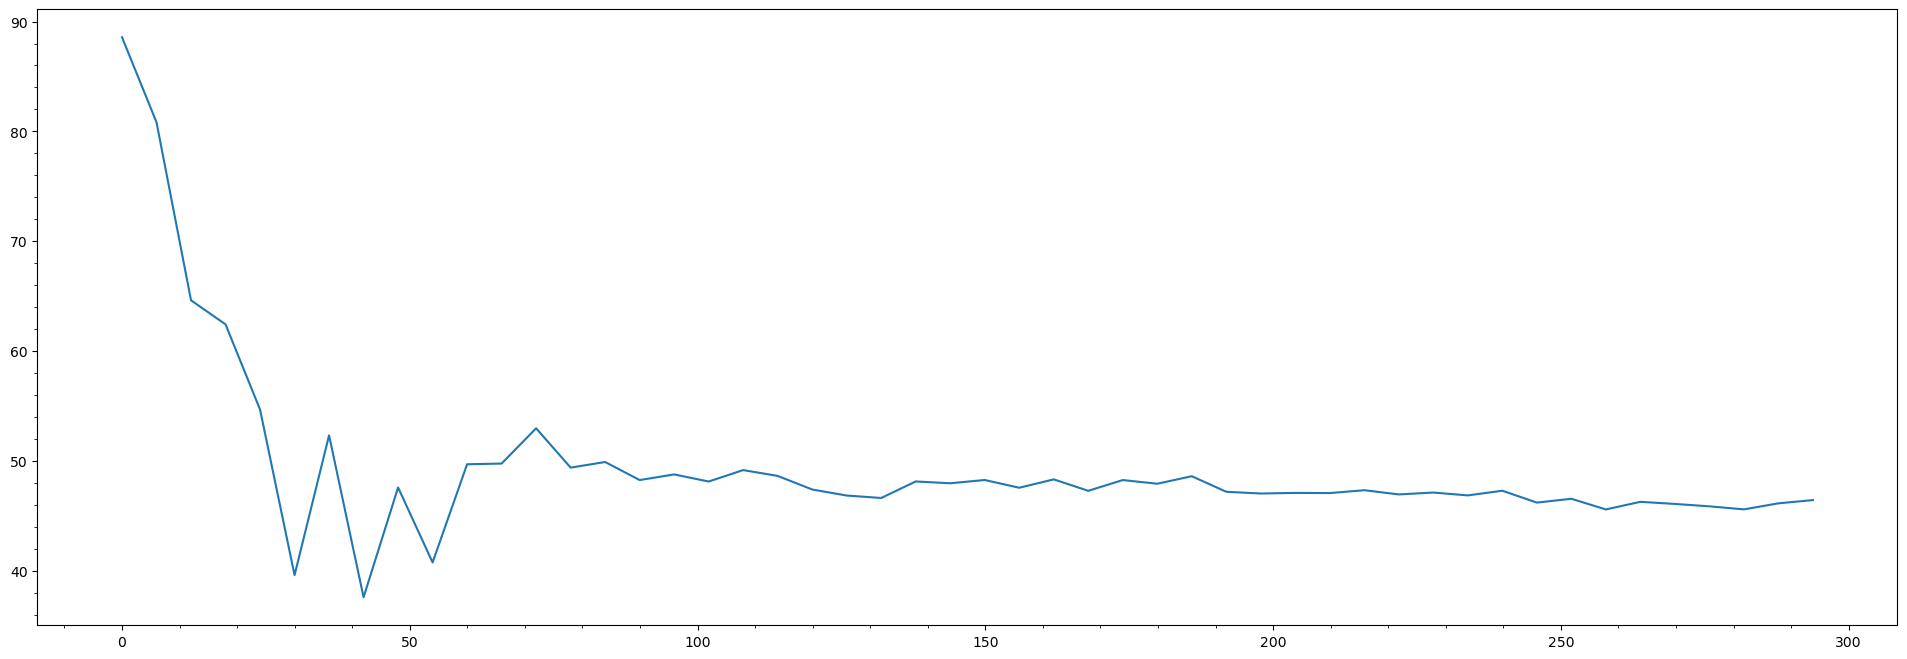

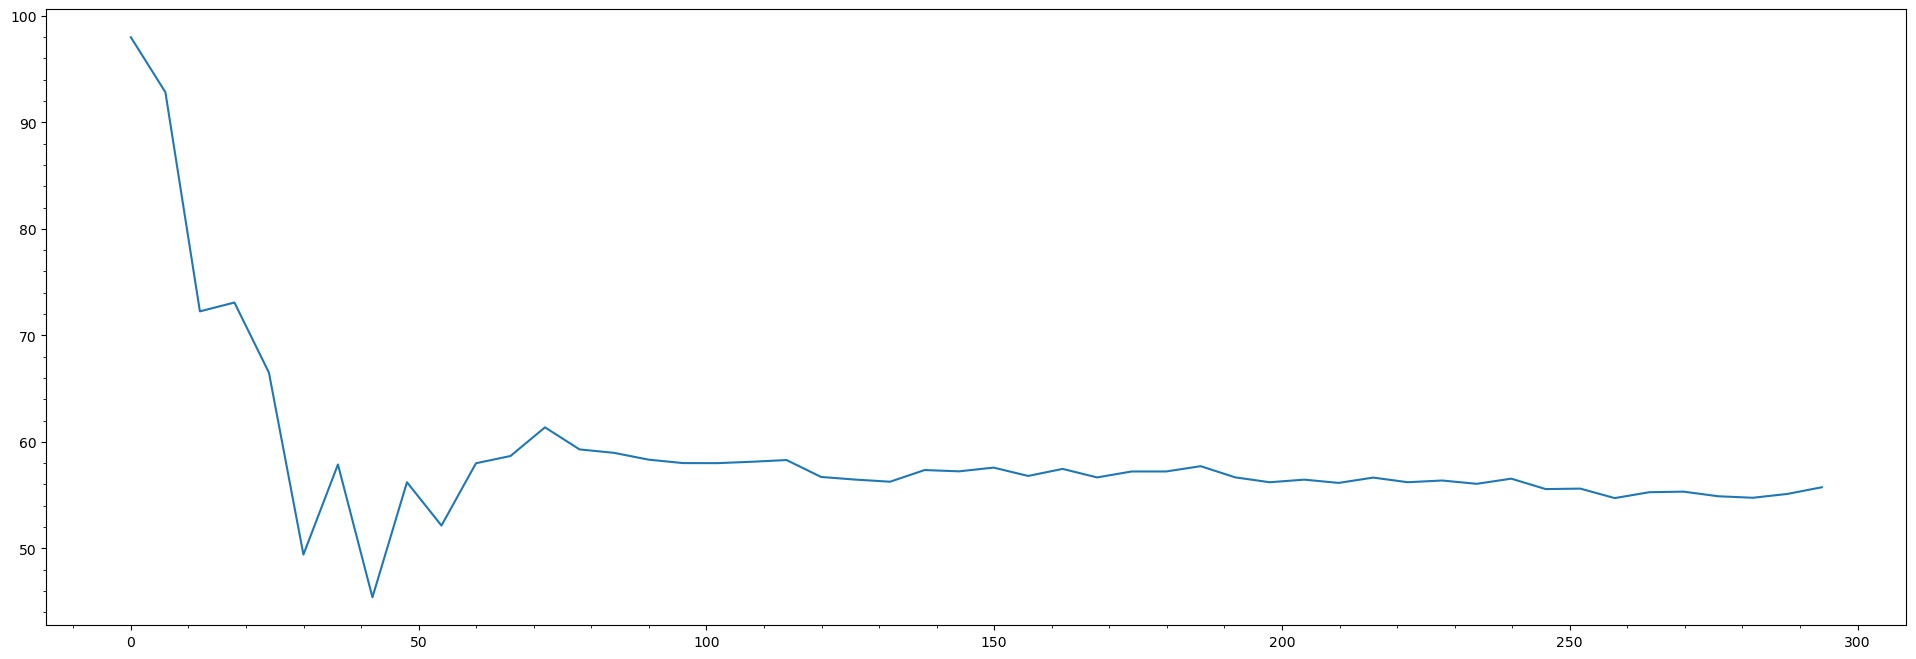

In [12]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

pulse_sum_0 = cpi("../outputs/outputs4/lab_cr_0.bin",template_signal)
pulse_sum_1 = cpi("../outputs/outputs4/lab_cr_1.bin",template_signal)
pulse_sum_2 = cpi("../outputs/outputs4/lab_cr_2.bin",template_signal)
#pulse_sum_3 = cpi("../outputs/outputs4/lab_cr_3.bin",template_signal)

pulse_sum = pulse_sum_0 + pulse_sum_1 + pulse_sum_2 #+ pulse_sum_3

plt.figure(figsize=(24,8))
#plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)))
#plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)))
#plt.plot(ranges,20*np.log10(np.abs(pulse_sum_3)))
plt.minorticks_on()
plt.show()

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.show()